In [ ]:
from pathlib import Path

import hvplot.polars
import polars as pl

dpath = Path("/home/hduva/projects/data/p3ht")
# get all "all.parquet" rglobed

all_files = list(dpath.rglob("*/*refl/all.parquet"))

dfs = []
for f in all_files:
    df = pl.scan_parquet(f)
    dfs.append(df)
# concatenate all dataframes
df = pl.concat(dfs).collect()
df = df.with_columns(
    pl.col("File Name").str.split("_").list.first().alias("File Name"),
)
df = df.filter(pl.col("Q [Å⁻¹]").gt(0.0).alias("Q [Å⁻¹]"))
df

File Name,EPU Polarization [deg],Beamline Energy [eV],Q [Å⁻¹],r [a. u.],δr [a. u.]
str,f64,f64,f64,f64,f64
"""baresi""",190.0,280.0,0.004953,0.698489,0.140059
"""baresi""",190.0,280.0,0.005379,0.651404,0.135441
"""baresi""",190.0,280.0,0.005805,0.579229,0.128069
"""baresi""",190.0,280.0,0.006231,0.747633,0.144734
"""baresi""",190.0,280.0,0.006646,0.606327,0.130877
…,…,…,…,…,…
"""p3ht""",190.0,282.5,0.10412,0.002966,0.005036
"""p3ht""",190.0,282.5,0.108334,0.00229,0.005719
"""p3ht""",190.0,282.5,0.11253,0.001689,0.00665


In [ ]:
p = df.hvplot.scatter(  # type: ignore
    x="Q [Å⁻¹]",
    y="r [a. u.]",
    by=["File Name", "Beamline Energy [eV]"],
    title="Reflectivity",
    height=600,
    width=1200,
    muted_alpha=0,
).opts(
    legend_position="top_right",
    logy=True,
    xlim=(0, df["Q [Å⁻¹]"].max() * 1.1),  # type: ignore
    ylim=(1e-10, df["r [a. u.]"].max() * 1.1),  # type: ignore
)
p

:NdOverlay   [File Name,Beamline Energy [eV]]
   :Scatter   [Q [Å⁻¹]]   (r [a. u.])

In [ ]:
"""
Some amount of copyright:

"""
import copy

# Required modules:
import os
import warnings

import matplotlib.colors as mpl_colors

# Plotting module
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Module to load .fits files
from astropy.io import fits
from numba import njit

# Scipy for image filtering and stitching
from scipy import ndimage
from scipy.odr import ODR, Model, RealData
from scipy.optimize import curve_fit

# Optional Packages for advanced functionality:
optional_packages = []
optional_packages.append(("h5py", None))
optional_packages.append(("skimage.feature", ["blob_dog", "blob_log", "blob_doh"]))
optional_packages.append(("skimage.draw", ["disk"]))
# Add more if necessary and code expands

# Keep track for later
loaded_packages = {}
for package, module in optional_packages:
    try:
        if module is None:
            globals()[package].split(".")[0] = __import__(package)
        else:
            globals()[module] = getattr(__import__(package, fromlist=[module]), module)
        loaded_packages[package] = True
    except:
        loaded_packages[package] = False

# Constants used for data reduction
sol = 299792458  # [m/s] Speed of light
planck_joule = 6.6267015e-34  # [Joule s] # Plancks constant
elemcharge = 1.602176634e-19  # [coulombs] # Charge of electron
planck = planck_joule / elemcharge  # [eV s]
metertoang = 10**10  # Convert meters to Angstroms

# Functions that can be used to filter image to find beamspot
verified_filters = [("gauss", ndimage.median_filter)]
verified_locate_methods = ["argmax"]

# Default motors that can be adjusted for reflectivity.
default_variable_motors = [
    "Higher Order Suppressor",
    "Horizontal Exit Slit Size",
    "EXPOSURE",
]

# Motor Names that are pulled from header files
energy_motor = "Beamline Energy"
energy_resolution = 1  # Decimal Points

pol_motor = "EPU Polarization"
pol_resolution = 0  # Decimal Points

angle_motor = "T-2T"
exposure_motor = "EXPOSURE"
beamcurrent_motor = "Beam Current"

# Detector Information from manufacturer
dark_current = 0.0015  # [e/pixel/s]
read_noise = {"100kHz": 6.5, "1MHz": 10.5}  # (e- rms) @ readout speed
gain = {"low": 5, "medium": 1.7, "high": 0.7}  # e-/ADU

# Plotting defaults
default_cmap = "terrain"


def row_by_row_subtraction(image: np.ndarray) -> np.ndarray:
    """Subtract the average of the left or right side of the image."""
    left = image[:, :20]
    right = image[:, -20:]
    if left.sum() < right.sum():
        # subtract row by row the average of the right side
        image = image - right.mean(axis=1)[:, None]
    else:
        image = image - left.mean(axis=1)[:, None]
    return image


class PXRImage:
    """
    Class that contains metadata and image processing for a single fits file used in PRSOXR data reduction

    Parameters:
    -----------

    Attributes
    ----------
    stuff


    """

    def __init__(self, image=None, metadata={}, autoload=False, **kwargs):
        # Critical information about file
        self.meta = metadata  # Store image metadata with the 2D image
        self.simplify_meta()  # Use this to round specific motor positions to allow for indexing
        self.update_args(**kwargs)  # Update attributes to help with data reduction
        # Save data locally to the object
        self.image = image  # Save the image locally and trim edges if requested

        if autoload == True:
            self.process_image()  # Hiding this behind an initialization to reduce initial load time (no image filtering unless checkspot called)

    def update_args(self, **kwargs):
        # Offsets that are external to the meta-data
        self.energy_offset = kwargs.get(
            "energy_offset", getattr(self, "energy_offset", 0)
        )
        self.exposure_offset = kwargs.get(
            "exposure_offset", getattr(self, "exposure_offset", 0)
        )
        self.angle_offset = kwargs.get("angle_offset", getattr(self, "angle_offset", 0))

        # Extract metadata and apply offsets if necessary
        self.energy = self.meta[energy_motor] + self.energy_offset
        self.angle = self.meta[angle_motor] + self.angle_offset
        self.exposure = self.meta[exposure_motor] + self.exposure_offset
        self.beam_current = (
            self.meta[beamcurrent_motor] if self.meta[beamcurrent_motor] > 50 else 1
        )  # Change to 1 if it did not record
        self.polarization = self.meta[pol_motor]

        # Methods used to filter image and locate beam
        self._filter = kwargs.get(
            "filter_func", getattr(self, "_filter", ndimage.median_filter)
        )
        self._filter_kwargs = kwargs.get(
            "filter_kwargs", getattr(self, "_filter_kwargs", {"size": 3})
        )
        self._locate_beam_method = kwargs.get(
            "loc_method", getattr(self, "_locate_beam_method", "argmax")
        )
        self._locate_beam_dict = {}
        self.height = kwargs.get("height", getattr(self, "height", 10))
        self.width = kwargs.get("width", getattr(self, "width", 10))
        self._darkside = kwargs.get("darkside", getattr(self, "darkside", "LHS"))

        # Image masking steps
        self.edge = kwargs.get("edge", getattr(self, "edge", (5, 5)))
        self.dx = self.edge[0]  # I am going to trim things early
        self.dy = self.edge[1]  # I am going to trim things early

        # Get the mask if needed
        self.mask = kwargs.get("mask", getattr(self, "mask", None))
        # if self.mask is None: # Quick check
        #    self.mask = np.full((self._image.shape[0],self._image.shape[1]), True, dtype=bool)
        # Trim the mask
        # self.mask = self.mask[self.dx:-self.dx,self.dy:-self.dy]

    @property
    def image(self):
        return self._image

    @image.setter
    def image(self, image):
        if not isinstance(image, np.ndarray):
            raise TypeError(
                f"Image must be a 2D Numpy array, but got {type(value).__name__} instead."
            )
        try:
            self._image = image[self.dx : -self.dx, self.dy : -self.dy]
        except AttributeError:
            self._image = image

    def process_image(
        self, **kwargs
    ):  # Process the image given **kwargs from the loader.
        # If arguments need to be changed, do that now
        self.update_args(**kwargs)
        # Create filtered image here based on options in kwargs
        self._filtered_image = self._filter(self.image, **self._filter_kwargs)
        self._zinged_image = dezinger_image(self.image, med_result=self._filtered_image)
        # subtract the dark current row by row
        self._zinged_image = row_by_row_subtraction(self._zinged_image)
        # Calculate spot using algorithm given in kwargs
        self.update_spot()
        self.update_dark()
        self.reduce_2D_image()

    @property
    def meta(self):
        return self._metadata

    @meta.setter
    def meta(self, meta):
        self._metadata = meta

    @property
    def energy(self):
        return self._energy

    @energy.setter
    def energy(self, energy):
        try:
            energy = float(energy)
        except TypeError as e:
            print(e)
        self._energy = energy
        if hasattr(self, "_angle"):
            self.qval = theta_to_q(self._angle, energy_to_wavelength(self._energy))

    @property
    def angle(self):
        return self._angle

    @angle.setter
    def angle(self, angle):
        try:
            angle = float(angle)
        except TypeError as e:
            print(e)

        if -200 < angle < -5:
            self._angle = angle + 180  # Mounted on the bottom of the holder
        else:
            self._angle = angle  # Mounted on the top of the holder

        self.angle_rad = np.radians(self._angle)
        if hasattr(self, "_energy"):
            self.qval = theta_to_q(self.angle_rad, energy_to_wavelength(self._energy))

    @property
    def height(self):
        return self._height

    @height.setter
    def height(self, value):
        if not isinstance(value, int):
            warnings.warn(
                f"Height must be an int, but got {type(value).__name__}. Converting to int.",
                UserWarning,
            )
            try:
                value = int(np.round(value, 0))
            except ValueError:
                print("Cannot convert Height to int. Using default value")
                value = 10
        self._height = value

    @property
    def width(self):
        return self._width

    @width.setter
    def width(self, value):
        if not isinstance(value, int):
            warnings.warn(
                f"Width must be an int, but got {type(value).__name__}. Converting to int.",
                UserWarning,
            )
            try:
                value = int(np.round(value, 0))
            except ValueError:
                print("Cannot convert width to int. Using default value")
                value = 10
        self._width = value

    @property
    def edge(self):
        return self._edge

    @edge.setter
    def edge(self, value):
        if not isinstance(value, tuple):
            if not isinstance(value, int):
                warnings.warn(
                    f"Edge trim must be an int, but got {type(value).__name__}. Converting to int.",
                    UserWarning,
                )
                try:
                    value = (int(np.round(value, 0)), int(np.round(value, 0)))
                except ValueError:
                    print("Cannot convert edge trim to int. Using default values")
                    value = 5
            self._edge = (value, value)
        else:
            out = ()
            for dim in value:
                if not isinstance(dim, int):
                    warnings.warn(
                        f"Edge trim must be an int, but got {type(value).__name__}. Converting to int.",
                        UserWarning,
                    )
                    try:
                        out = out + (int(np.round(dim, 0)),)
                    except ValueError:
                        print("Cannot convert edge trim to int. Using default values")
                        out = out + (int(np.round(dim, 0)),)
                else:
                    out = out + (dim,)
            self._edge = out

    def update_spot(self):
        """
        Function to slice an image around the beamspot located using self._locate_beam

        """
        h = self.height
        w = self.width
        # Mask the image
        temp_image = self._filtered_image.copy()
        if self.mask is not None:
            temp_image[~self.mask] = 0

        # Find the beam center
        y_spot, x_spot = locate_peak(
            temp_image, self._locate_beam_method, **self._locate_beam_dict
        )

        # Always assume a box shape
        y_low_bound = y_spot - (h // 2)
        x_low_bound = x_spot - (w // 2)
        s11 = slice(y_low_bound, y_low_bound + h)
        s12 = slice(x_low_bound, x_low_bound + w)
        s1_spot = (s11, s12)
        # Calculate the rectangle for plotting
        rectangle = plt.Rectangle(
            (x_low_bound, y_low_bound), w, h, edgecolor="yellow", facecolor="None"
        )

        self.spot = self.image[s1_spot]
        self.xloc = x_spot
        self.yloc = y_spot
        self.rect_spot = rectangle

        # return self.image[s1_spot], x_spot, y_spot, rectangle

    def update_dark(self):
        """
        Function to slice an image around the beamspot located using self._locate_beam

        """

        image = self._zinged_image
        h = self.height
        w = self.width

        # Get the y-position
        y_dark = self.yloc - (h // 2)
        # Get the x-position
        if self._darkside == "LHS":
            x_dark = 0
        elif self._darkside == "RHS":
            x_dark = image.shape[1] - w

        sl1 = slice(y_dark, y_dark + h)
        sl2 = slice(x_dark, x_dark + w)
        sl_dark = (sl1, sl2)
        image_dark = image[sl_dark]
        # Calculate a rectangle for plotting
        rect_dark = plt.Rectangle(
            (x_dark, y_dark), w, h, edgecolor="red", facecolor="None"
        )

        self.dark = image_dark
        self.xdark = x_dark
        self.ydark = y_dark
        self.rect_dark = rect_dark

        # return image_dark, x_dark, y_dark, rect_dark

    def reduce_2D_image(self, G=gain["high"], RON=read_noise["1MHz"]):
        """
        Function to reduce the 2D image into the reflectivity and associated error

        """

        # Sliced images for light and dark
        image_spot = self.spot  # in ADU
        image_dark = self.dark  # in ADU

        # Normalization values
        exposure = self.exposure
        beamcurrent = self.beam_current

        # Compute counts
        image_spot_err = np.sqrt(image_spot * G) / G  # Counting uncertainty in ADU
        image_dark_err = np.sqrt(image_dark * G) / G  # Counting uncertainty in ADU

        # Calculate the total counts and add uncertainty in quadrature
        i_tot = int(image_spot.sum())  # total counts in the beam location
        # i_tot_err = np.sqrt((np.square(image_spot_err)).sum())
        i_dark = int(
            image_dark.sum()
        )  # Total counts near the edge of the detector within the same integrated box
        # i_dark_err = np.sqrt((np.square(image_dark_err)).sum())

        # Calculate total reflectivity
        i_refl = i_tot - i_dark  # total counts
        # i_refl_err = np.sqrt((i_tot_err)**2 + (i_dark_err)**2)
        i_refl_err = np.sqrt(i_tot + i_dark) / i_tot

        # Normalize reflectivity to exposure/beam current (ai3?)
        r = i_refl / (exposure * beamcurrent)
        r_err = i_refl_err / (exposure * beamcurrent)

        snr = float(
            i_refl / np.abs(i_refl_err)
        )  # A quick check to determine if there are enough counts to confirm that the beam is captured

        # Save for checkspot and debugging
        self.itot = i_tot
        self.idark = i_dark
        # Save for refl processing
        self.r = r
        self.r_err = r_err
        self.snr = snr

        # return r, r_err, snr

    def update_image(self, **kwargs):
        self.update_args(self, **kwargs)
        self.update_spot()
        self.update_dark()
        self.reduce_2D_image()

    def simplify_meta(self):
        self.meta[energy_motor] = np.round(self.meta[energy_motor], energy_resolution)
        self.meta[pol_motor] = np.round(self.meta[pol_motor], pol_resolution)


def locate_peak(image, method, **kwargs):
    if method == "argmax":
        y_spot, x_spot = np.unravel_index(np.argmax(image), image.shape)

    else:  # No choice was given
        print("How did you get here? Your data will not look correct...")
        return 0, 0

    return y_spot, x_spot


class PrsoxrLoader:
    """
    Loader for PRSoXR data from beamline 11.0.1.2 taken with the CCD camera.

    Parameters
    -----------
    files : list
        List of .fits to be loaded. Include full filepaths

        >>> # Recommended Usage
        >>> import pathlib
        >>> path_s = pathlib.Path("../ALS/2020 Nov/MF114A/spol/250eV")
        >>> files = list(path_s.glob("*fits"))  # All .fits in path_s

        The newly created 'files' is now a list of filepaths to each reflectivity point.

    name : str
        Name associated with the dataset. Only used for saving data to disk.

    mask : np.ndarray (Boolean)
        Array with dimensions equal to an image. Elements set to `False` will be excluded when finding beamcenter.

        >>> # Recommended usage
        >>> loader = loader = PrsoxrLoader(files)
        >>> mask = np.full_like(loader.images[0], True, dtype=bool)
        >>> mask[:50, :50] = False  # block out some region
        >>> loader.mask = mask

    autoload : Boolean
        Set to false if you do not want to load the data upon creation of object.

    Attributes
    -----------
    name : str
        Human readable string that describes the dataset to be loaded. See 'name' parameter
    mask : np.ndarray (Bool)
        Data mask to be applied to all images.
    files : list
        List of filepaths
    shutter_offset : float
        Deadtime added to the piezo shutter exposure.
        >>> total_exposure = frame_exposure + shutter_offset
         It is recommended to measure at the time of taking data (see online tutorial)
    sample_location : int
        Sample location on the holder:
        Bottom of holder == 180, Top of holder == 0. Should be automatically updated when files load
    angle_offset : float
        Angle offset [deg] to be added to 'Sample Theta' to correctly calculate q. (see online tutorial)
    energy_offset : float
        Energy offset [eV] to be applied to 'Beamline Energy' to correctly calculate q.
    snr_cutoff : float
        snr is the ratio of light counts vs. dark counts for images used in calculated total signal.
        Any image found below this threshold will be excluded from processing.
        It is assumed that under this condition the beam is attenuated enough that we are unable to locate its center.
        Default value is 1.01 and is suitable for the ALS in most cases.
    variable_motors : list(str)
        List of upstream optics that were varied to modify flux during data collection.
        Defaults are Horizontal Exit Slit Size and Higher Order Suppressor
    imagex : int
        X-dimension of .fits. Will be automatically updated when files load.
    imagey : int
        Y-dimension of .fits. Will be automatically updated when files load
    edge_trim : tuple(int)
        Edge of the detector that you want to ignore in processing.
        Edge pixels can sometimes have higher background at longer exposures.
        Use this option to exclude them from finding the beamcenter.
        Typical value is (5, 5)
    darkside : 'LHS' or 'RHS'
        Side of the detector that you want to take dark image.
        The same size ROI will be chosen but offset to the edge of the detector.
        Will not include pixels cut by edge_trim.
    diz_threshold : int
        Dizinger intensity threshold to remove 'hot' pixels.
    diz_size : int
        Size of box to average to remove 'hot' pixels.

    Notes
    ------

    Print the loader to view variables that will be used in reduction. Update them using the attributes listed in this API.

    >>> loader = PrsoxrLoader(files, name="MF114A_spol")
    >>> print(loader)  # Default values
        Sample Name - MF114A
        Number of scans - 402
        ______________________________
        Reduction Variables
        ______________________________
        Shutter offset = 0.00389278
        Sample Location = 0
        Angle Offset = -0.0
        Energy Offset = 0
        SNR Cutoff = 1.01
        ______________________________
        Image Processing
        ______________________________
        Image X axis = 200
        Image Y axis = 200
        Image Edge Trim = (5, 5)
        Dark Calc Location = LHS
        Dizinger Threshold = 10
        Dizinger Size = 3
    >>>loader.shutter_offset = 0.004 #Update the shutter offset
    >>>

    Once process attributes have been setup by the user, the function can be called to load the data. An ROI will need
    to be specified at the time of processing. Use the ``self.check_spot()`` function to find appropriate dimensions.

    >>> refl = loader(h=40, w=30)

    Data that has been loaded can be exported using the ``self.save_csv(path)`` and ``self.save_hdf5(path)`` functions.

    """

    def __init__(self, files, name=None, mask=None, autoload=True):
        # Sample information
        self.files = files  # List of pathlib paths that lead to .fits to be loaded
        self._mask = mask  # Mask that will block individual pixels from being loaded/used in analysis
        self._name = name  # Name of the series to be loaded, used in saving

        # offset variables not stored in metadata
        self._exposure_offset = 0.00389278  # [s] # Default for piezo shutter
        # self.sample_location = 0  # sample on bottom of holder = 180, sample on top = 0 No longer necessary?
        self._angle_offset = 0  # [deg] # External value if it did not start at 0
        self._energy_offset = 0  # [eV] # External value determined by some other means

        # Uncertainty cutoff options
        # self.percent_error = 1.5  # [%] Uncertainty option (legacy option)
        self._snr_cutoff = 1.003  # SNR = I_refl/dark ~ Cutoff on if frame is ignored.#

        # Motors that are moved
        self.variable_motors = copy.deepcopy(
            default_variable_motors
        )  # Now including EXPOSURE
        self._height = 10  # [pixels]
        self._width = 10  # [pixels]

        # Image stats
        self._edge_trim = (5, 5)
        self._darkside = "LHS"

        # Method to locate beam data
        self._available_locate_methods = copy.deepcopy(verified_locate_methods)
        self._loc_method = "argmax"  # Default method

        # Choice to filter image and find beam center
        self._available_filters = copy.deepcopy(verified_filters)
        self._filter_func = ndimage.median_filter
        self._filter_kwargs = {"size": 3}

        # Build storage lists
        self.PXRImages = []  # List of PXRImage objects that have processed information. #
        self.images = []  # List that contains all PXRImage's

        # Ways to save meta-data (needs to be cleaned up)
        self._meta_list = []
        self._meta_dict = {}
        self.meta = []  # List that contains all the meta-data dictionaries

        self._scale_factors = []
        self._stitch_points = []

        self.image_data = []
        self._normalized_data = []

        self._refl = []
        self.update_kwargs()

        if autoload:
            for i, file in enumerate(self.files):
                image_i, meta_i = load_fits(file)
                self.PXRImages.append(
                    PXRImage(image=image_i, metadata=meta_i, **self.image_kwargs)
                )  # Store and process data
                self._images.append(image_i)
                self._meta_list.append(meta_i)
            # Create a compiled dataframe of metadata.#
            self._meta_dict = {
                key: [d[key] for d in self._meta_list]
                for key in self._meta_list[0].keys()
            }
            self.meta = pd.DataFrame(self._meta_dict)
            # self.simplfy_meta() # Round the energy & polarization

    @property
    def name(self):
        return self._name

    @name.setter
    def name(self, name):
        self._name = name

    @property
    def mask(self):
        return self._mask

    @mask.setter
    def mask(self, mask):
        self._mask = mask
        self.update_kwargs()

    # Values that are offsets
    @property
    def exposure_offset(self):
        return self._exposure_offset

    @exposure_offset.setter
    def exposure_offset(self, val):
        self._exposure_offset = val
        self.update_kwargs()

    @property
    def angle_offset(self):
        return self._angle_offset

    @angle_offset.setter
    def angle_offset(self, val):
        self._angle_offset = val
        self.update_kwargs()

    @property
    def energy_offset(self):
        return self._energy_offset

    @energy_offset.setter
    def energy_offset(self, val):
        self._energy_offset = val
        self.update_kwargs()

    # Other processing parameters
    @property
    def snr_cutoff(self):
        return self._snr_cutoff

    @snr_cutoff.setter
    def snr_cutoff(self, val):
        self._snr_cutoff = val
        self.update_kwargs()

    @property
    def height(self):
        return self._height

    @height.setter
    def height(self, val):
        self._height = val
        self.update_kwargs()

    @property
    def width(self):
        return self._width

    @width.setter
    def width(self, val):
        self._width = val
        self.update_kwargs()

    @property
    def edge_trim(self):
        return self._edge_trim

    @edge_trim.setter
    def edge_trim(self, val):
        self._edge_trim = val
        self.update_kwargs()

    @property
    def darkside(self):
        return self._darkside

    @darkside.setter
    def darkside(self, val):
        self._darkside = val
        self.update_kwargs()

    @property
    def loc_method(self):
        return self._loc_method

    @loc_method.setter
    def loc_method(self, method):
        if method in self._available_location_methods:
            self.loc_method = method
        else:
            print("Method unavailable, returning to default")
            self.loc_method = "argmax"
        self.update_kwargs()

    @property
    def filter_func(self):
        return self._filter_func

    @filter_func.setter
    def filter_func(self, method):
        for name, func in self._available_filters:
            if method == name:
                self._filter_func = func
            else:
                print("Filter unavailable, applying default filter")
                self._filter_func = ndimage.median_filter
        self.update_kwargs()

    @property
    def filter_kwargs(self):
        return self._filter_kwargs

    @filter_kwargs.setter
    def filter_kwargs(self, d):
        self._filter_kwargs = d
        self.update_kwargs()

    def update_kwargs(self):
        # Gather keyward args for calculating reflectivity (This all sounded better in my head)
        properties = {
            attr: getattr(self, attr)
            for attr in dir(self)
            if isinstance(getattr(type(self), attr, None), property)
        }
        remove = ["images", "meta"]
        self.image_kwargs = {k: v for k, v in properties.items() if k not in remove}

    @property
    def images(self, energy=None, polarization=None):
        """
        Call a list that includes all images  associated with an energy & polarization.
        Use self.meta to call the associated metadata using this method.
        """
        if energy == None and polarization == None:
            return self._images
        df = self._meta
        # Get pol if default
        if polarization == None:
            polarization = float(
                np.round(df[pol_motor].value_counts().idxmax(), pol_resolution)
            )  # Get the polarization that shows up the most (default)
        # Find the energies that matches
        df["difference"] = abs(
            np.round(df[energy_motor], energy_resolution) - energy
        )  # Find the closest value to the given energy
        df["difference_pol"] = abs(
            np.round(df[pol_motor], pol_resolution) - polarization
        )
        df = df.loc[df["difference"] == df["difference"].min()].copy()
        df = df.loc[df["difference_pol"] == df["difference_pol"].min()]

        return [self._images[i] for i in df.index]

    @images.setter
    def images(self, images):
        self._images = images

    @property
    def meta(self, energy=None, polarization=None):
        """
        Call a dataframe that includes all image metadata associated with an energy & polarization
        """
        if energy == None and polarization == None:
            return self._meta
        df = self._meta
        # Get pol if default
        if polarization == None:
            polarization = float(
                np.round(df[pol_motor].value_counts().idxmax(), pol_resolution)
            )  # Get the polarization that shows up the most (default)
        # Find the energies that matches
        df["difference"] = abs(
            np.round(df[energy_motor], energy_resolution) - energy
        )  # Find the closest value to the given energy
        df["difference_pol"] = abs(
            np.round(df[pol_motor], pol_resolution) - polarization
        )
        df = df.loc[df["difference"] == df["difference"].min()].copy()
        df = df.loc[df["difference_pol"] == df["difference_pol"].min()]

        return df.drop(columns=["difference", "difference_pol"])

    @meta.setter
    def meta(self, df):
        self._meta = df

    def __str__(self):
        s = []  # ["{:_>50}".format("")]
        s.append("Sample Name - {0}".format(self.name))
        s.append("Number of scans - {0}".format(len(self.files)))
        s.append("{:_>30}".format(""))
        s.append("Reduction Variables")
        s.append("{:_>30}".format(""))
        s.append("Shutter offset = {0}".format(self.exposure_offset))
        s.append("Angle Offset = {0}".format(self.angle_offset))
        s.append("Energy Offset = {0}".format(self.energy_offset))
        s.append("SNR Cutoff = {0}".format(self.snr_cutoff))
        s.append("{:_>30}".format(""))
        s.append("Image Processing")
        s.append("{:_>30}".format(""))
        s.append("Image Edge Trim = {0}".format(self.edge_trim))
        s.append("Dark Calc Location = {0}".format(self.darkside))

        return "\n".join(s)

    def __call__(self, xvar="Q", tol=2):
        return self._calc_refl(xvar=xvar, tol=tol)

    def __len__(self):
        return len(self.files)

    def optimize_box(
        self, dim_list=np.arange(1, 42, 2), frame=0, tol=0.9, replace=False, d=1
    ):
        """
        Find the box width/height in which we collect 90% of the input light.
        """
        old_h = self.height
        old_w = self.width
        i0_calc = []
        snr_list = []
        for x in dim_list:
            # Update the process kwargs to go into PXRImage
            self.height = int(x)
            self.width = int(x)
            temp_image = PXRImage(
                self._images[frame],
                self._meta_list[frame],
                autoload=True,
                **self.image_kwargs,
            )
            # i_tot = int(temp_image.spot.sum())
            # i_dark = int(temp_image.dark.sum())
            i_tot = temp_image.itot
            i_dark = temp_image.idark
            snr = temp_image.snr
            i0_calc.append(i_tot - i_dark)
            snr_list.append(snr)

        i0_calc = np.array(i0_calc)
        snr_list = np.array(snr_list)

        max_count = np.max(i0_calc)
        opt_size = int(np.interp(tol * max_count, i0_calc, dim_list))
        opt_size = int(opt_size) + 1 if opt_size % 2 == 0 else int(opt_size)

        if replace:
            self.height = int(opt_size)
            self.width = int(opt_size)
        else:
            self.height = int(old_h)
            self.width = int(old_w)

        print(f"Optimum box size for this experiment: {opt_size} pixels.")

        if d:
            fig, ax = plt.subplots(1, 1, figsize=(4, 4))
            ax.set_title("Total reflectivity using different box dimensions")
            ax.plot(
                dim_list,
                i0_calc,
                ms=3,
                marker="x",
                lw=1,
                color="black",
                label="Total Counts",
            )
            ax.axvline(x=opt_size, color="r")
            # ax.plot(opt_size, max_count*tol, ms=5, marker='o', lw=0, color='red')

            ax2 = ax.twinx()
            ax2.plot(
                dim_list, snr_list, ms=3, marker="x", lw=1, color="blue", label="snr"
            )

            ax.set_xlabel("Pixels")
            ax.set_ylabel("Total Counts", color="black")
            ax2.set_ylabel("snr", color="blue")
            plt.show()

    def check_spot(self, index, h=18, w=15, d=True):
        """
        Function to quickly load, reduce, and display a single frame.

        Parameters
        ----------
            index : int
                Frame index to view. Extracts data from self.image and self.meta
            h : int (even number)
                height of ROI used to calculate reflectivity. Center is defined as pixel with hightest magnitude.
            w : int (even number)
                width of ROI used to calculate reflectivity. Center is defined as pixel with hightest magnitude.
            d : Boolean
                Display a summary plot
        Returns
        --------
            processed images : list
                Arrays of the following images: Raw Image, Median Filter, Beam spot, dark frame
        Notes
        ------
        Process a single image according to chosen process variables.
        Will use: ``self.edge_trim``, ``self.mask``, ``self.darkside``, ``self.diz_threshold``, and ``self.diz_size``
        Output will include important motor positions for the select file.
        If d==1, the images will be displayed according to the output. Black rectangle represents the beam spot.
        Red rectangle represents the dark frame.

        >>> # Quickly verify image stats
        >>> frame = loader.check_spot(file=11, h=40, w=20)
            Exposure: 0.00100000004749745
            Beam Current: 0.0
            Angle Theta: 1.112
            T-2T: 1.112
            CCD Theta: 2.221
            Photon Energy: 249.996035379532
            Polarization: 100.0
            Higher Order Suppressor: 11.9997548899767
            Horizontal Exit Slit Size: 100.0
            Processed Variables:
            Q: 0.004916964189179494
            Specular: 845685
            Background: 115456
            Signal: 730229
            SNR: 7.32473842849224
            Beam center (85, 51)
        >>>

        """
        # Try and load the image
        if index > len(self.files) + 1:
            print(f"Only {len(self.files)} files locally stored, unable to load index")
            return 0

        # Save previous conditions to return too.#
        old_h = int(self.height)
        old_w = int(self.width)

        # Edit height and width
        self.height = h
        self.width = w

        # Load the image
        image = self.images[index]
        meta = self._meta_list[index]

        # Process image
        processed_image = PXRImage(image, meta, autoload=True, **self.image_kwargs)

        # Get processing conditions
        image_plot = processed_image._zinged_image
        image_spot = processed_image.spot
        image_avg = processed_image._filtered_image
        beamspot = (processed_image.xloc, processed_image.yloc)
        rect_spot = processed_image.rect_spot

        image_dark = processed_image.dark
        rect_dark = processed_image.rect_dark

        i_refl = processed_image.itot
        i_dark = processed_image.idark
        snr = processed_image.snr

        # i_refl = int(image_spot.sum())
        # dark = int(image_dark.sum())
        # snr = float((i_refl / np.abs(dark)))  # "signal to noise ratio"

        # Import
        energy = processed_image.energy
        angle_theta = processed_image.angle
        qval = processed_image.qval

        # Relevant outputs that you would want to read.
        print("Exposure: {}".format(meta["EXPOSURE"]))
        print("Beam Current: {}".format(meta["Beam Current"]))
        print("Angle Theta: {}".format(meta["Sample Theta"]))
        print("T-2T: {}".format(meta["T-2T"]))
        print("CCD Theta: {}".format(meta["CCD Theta"]))
        print("Photon Energy: {}".format(meta["Beamline Energy"]))
        print("Polarization: {}".format(meta["EPU Polarization"]))
        print("Higher Order Suppressor: {}".format(meta["Higher Order Suppressor"]))
        print("Horizontal Exit Slit Size: {}".format(meta["Horizontal Exit Slit Size"]))
        print("\n")
        print("Processed Variables:")
        print("Q:", qval)
        print("Specular:", i_refl)
        print("Background:", i_dark)
        print("Signal:", i_refl - i_dark)
        print("SNR:", snr)
        print("Beam center", beamspot)

        if d:
            fig, ax = plt.subplots(
                3, 2, subplot_kw={"xticks": [], "yticks": []}
            )  # , figsize=(12, 8))
            ax[0, 0].imshow(image_plot, norm=mpl_colors.LogNorm(), cmap=default_cmap)
            ax[0, 0].set_title("Raw Image")
            ax[0, 1].imshow(image_avg, norm=mpl_colors.LogNorm(), cmap=default_cmap)
            ax[0, 1].set_title("Filtered Image")

            # Mask if necessary
            if self.mask is not None:
                mask_display = np.ma.masked_where(self.mask == True, self.mask)
                ax[0, 0].imshow(mask_display, cmap="Greys_r")
                ax[0, 1].imshow(mask_display, cmap="Greys_r")

            # Add rectangles on each plot
            ax[0, 0].add_patch(rect_spot)
            ax[0, 0].add_patch(rect_dark)
            ax[0, 1].plot(beamspot[0], beamspot[1], "ro", ms=2)

            ax[1, 0].imshow(image_spot, cmap=default_cmap)
            ax[1, 0].set_title("Beam Shape lin-scale")

            ax[1, 1].imshow(image_dark, cmap=default_cmap)
            ax[1, 1].set_title("Dark Image lin-scale")

            ax[2, 0].imshow(image_spot, norm=mpl_colors.LogNorm(), cmap=default_cmap)
            ax[2, 0].set_title("Beam Shape log-scale")

            ax[2, 1].imshow(image_dark, norm=mpl_colors.LogNorm(), cmap=default_cmap)
            ax[2, 1].set_title("Dark Image log-scale")

            plt.tight_layout()
            plt.show()

        # Return to previous dimensions
        self.height = old_h
        self.width = old_w

        return [image, image_avg, image_spot, image_dark]  # Remove the edge, always

    def _calc_refl(self, xvar="Q", tol=2):
        """
        Function that performs a complete data reduction of prsoxr data
        """
        # Reinitialize some items to recreate them here
        self._normalized_data = []
        self._stitch_points = []
        self._scale_factors = []
        self._refl = []

        # First reduce all images into single values.#
        energy_list = self.meta[
            energy_motor
        ].unique()  # List of energies that are in dataset.#
        polarization_list = self.meta[
            pol_motor
        ].unique()  # List of polarizations that are in dataset.
        for pol in polarization_list:
            for en in energy_list:
                column_dict = {"Energy": en, "Polarization": pol}
                image_subset = [
                    image
                    for image in self.PXRImages
                    if image.energy == en and image.polarization == pol
                ]  # Get the images that matter
                for image in image_subset:
                    image.process_image(**self.image_kwargs)
                normalized_subset = self._normalize_data(image_subset)
                stitch_points = self._find_stitch_points(normalized_subset)
                scale_factors = self._calc_scale_factors(
                    stitch_points, normalized_subset
                )
                refl = self._stitch_refl(scale_factors, normalized_subset, xvar=xvar)
                # Add energy and polarization to the created dataframes (better way to do this?)
                for key, value in column_dict.items():
                    normalized_subset[key] = value
                    stitch_points[key] = value
                    scale_factors[key] = value
                    refl[key] = value
                # Append all dataframes to a list
                self._normalized_data.append(normalized_subset)
                self._stitch_points.append(stitch_points)
                self._scale_factors.append(scale_factors)
                self._refl.append(refl)

        self.normalized_data = pd.concat(self._normalized_data, axis=0).reset_index(
            drop=True
        )
        self.stitch_points = pd.concat(self._stitch_points, axis=0).reset_index(
            drop=True
        )
        self.scale_factors = pd.concat(self._scale_factors, axis=0).reset_index(
            drop=True
        )
        self.refl = pd.concat(self._refl, axis=0).reset_index(drop=True)

        return self.refl

    def _normalize_data(self, images):
        """
        Internal function that normalizes the image data to the direct beam
        """
        tmp_meta = [image.meta for image in images]
        # Get the motors ready
        variable_motors = copy.deepcopy(self.variable_motors)
        variable_motors.append("Sample Z")

        # Get data to work with
        tmp_data = {}
        tmp_data["Theta"] = [image.angle for image in images]
        tmp_data["Q"] = [image.qval for image in images]
        tmp_data["R"] = [image.r for image in images]
        tmp_data["R_err"] = [image.r_err for image in images]
        tmp_data["snr"] = [image.snr for image in images]

        # Compile into DataFrame for more use
        df_data = pd.DataFrame(tmp_data)
        df_meta = pd.DataFrame(
            {
                key: [d[key] for d in tmp_meta]
                for key in tmp_meta[0].keys()
                if key in variable_motors
            }
        )  # Get the variable motors in a dataframe.#
        df = pd.concat([df_data, df_meta.round(3)], axis=1)
        # Determine where the images that contain the direct beam
        try:
            i0_cutoff = df.loc[np.abs(df["Sample Z"].diff()) > 0.1].index[
                0
            ]  # The first position where we move from Z out of the way into the beam
            i0 = df["R"].iloc[:i0_cutoff].mean()
            i0_err = df["R_err"].iloc[:i0_cutoff].std()
        except IndexError:
            print("No direct beam found, normalizing to zero")
            i0_cutoff = -1
            i0 = 1
            i0_err = 0
        # Incorporate beam stability into the later images
        df["R_err"] = np.sqrt(
            (df["R"] / i0) ** 2 * ((df["R_err"] / df["R"]) ** 2 + (i0_err / i0) ** 2)
        )
        df["R"] = df["R"] / i0

        return df.drop(df.index[:i0_cutoff]).drop(columns=["Sample Z"])

    def _find_stitch_points(self, data_norm):
        """
        Internal function that locates the frames that one of the ``self.variable_motors`` has been changed.

        """
        df = data_norm[
            self.variable_motors
        ]  # Only take variable motors.drop(['index', 'Q', 'R', 'R_err'], axis=1)  # Use legacy code
        idx = []
        imotor = []
        skip = False
        skip_count = 0
        skip_count_reset = 2
        for motor in df.columns:
            for i, val in enumerate(np.diff(df[motor])):
                if skip:
                    if skip_count <= skip_count_reset:
                        skip_count += 1
                    else:
                        skip = False
                        skip_count = 0
                elif abs(val) > 1e-5:
                    # idx.append(i)
                    idx.append(
                        i + 1
                    )  # Edit TJF 1/14 : Moving mark up 1 space to better allow for fitting in later steps
                    imotor.append(motor)
                    skip = True
        dfx = pd.DataFrame([idx, imotor]).T
        dfx.columns = ["mark", "motor"]
        dfx = dfx.sort_values(by="mark", ascending=True)

        return dfx.drop_duplicates(
            subset=["mark"]
        )  # Remove duplicates if two adjustable motors are moved at the same time

    def _calc_scale_factors(self, stitch_points, data_norm):
        """
        Internal function that calcualtes the scale factor between ``self.variable_motors`` positions.

        """
        dfx = stitch_points  # self.stitch_points  # Use legacy code
        refl = data_norm  # self.normalized_data  # Use legacy code
        scale = 1
        scale_err = 0
        idq = []

        if not dfx.empty:
            # ['motor', 'value', 'Scale', 'Scale_Err', 'mark', 'skip']
            idq.append(
                [dfx.motor.iloc[0], refl[dfx.motor.iloc[0]].iloc[0], scale, 0, 0, 0]
            )  # Initialize the wave with the direct beam conditions

            for j, x in enumerate(dfx["mark"]):
                qstitch = refl["Q"].iloc[
                    x + 1
                ]  # The Qposition where we indicate the start of a "stitch"
                motor_change = dfx.motor.iloc[
                    j
                ]  # The motor that we are tracking for this 'mark' point
                # Pre-"mark" values to calculate stitch ratio
                dummy_q_list_pre = []
                dummy_r_list_pre = []
                dummy_err_list_pre = []
                # Post-"mark" values to calculate stitch ratio
                dummy_q_list_post = []
                dummy_r_list_post = []  # Dummy values to average together
                dummy_err_list_post = []  # Dummy errors to average together

                scalei = 1  # iterable scale
                scale_erri = 1  # iterable error
                motor_y = "None"  # init string

                # Calculate the number of datapoints are repeated after a move
                qrepeat = 0
                for i, val in enumerate(refl["Q"].iloc[x + 1 :]):
                    if (
                        val == qstitch
                    ):  # I have entered a region where qstitch matches the value
                        qrepeat += 1
                    else:  # I am no longer at the same repeated value
                        break

                # Calculate the 'pre' values for the stitch ratio
                for i, val in enumerate(
                    refl["Q"].iloc[:x]
                ):  # Start cycling through all values up to "Mark" when repeats happen.
                    if (
                        val in refl["Q"].iloc[x + qrepeat :].values
                        and val not in dummy_q_list_pre
                    ):  # Check if 'val' is ever repeated after the series of repeats (x+qindex)
                        dummy_q_list_pre.append(refl["Q"].iloc[i])
                        dummy_r_list_pre.append(
                            refl["R"].iloc[i]
                        )  # Capture the r-value
                        dummy_err_list_pre.append(
                            refl["R_err"].iloc[i]
                        )  # Capture the err-value
                # Calculate the post-'Mark' values for stitch ratio
                for i, val in enumerate(
                    refl["Q"].iloc[x + qrepeat :]
                ):  # Start cycling through all values
                    # Check if 'val' is ever before 'mark' AND check if we didnt accidently drop it previously from low SNR
                    if (
                        val in refl["Q"].iloc[:x].values
                        and val in dummy_q_list_pre
                        and val not in dummy_q_list_post
                    ):
                        dummy_q_list_post.append(refl["Q"].iloc[x + qrepeat + i])
                        dummy_r_list_post.append(refl["R"].iloc[x + qrepeat + i])
                        dummy_err_list_post.append(refl["R_err"].iloc[x + qrepeat + i])
                pre_stitch_elements = np.array(dummy_r_list_pre)
                pre_stitch_error = np.array(dummy_err_list_pre)
                post_stitch_elements = np.array(dummy_r_list_post)
                post_stitch_error = np.array(dummy_err_list_post)

                # Capture information
                motor_y = refl[motor_change].iloc[x + 1]  # Get the new motor position
                # Do a fit to find the stitch ratio
                linear = Model(stitchratio)
                mydata = RealData(
                    pre_stitch_elements,
                    post_stitch_elements,
                    sx=pre_stitch_error,
                    sy=post_stitch_error,
                )
                myodr = ODR(mydata, linear, beta0=[1.0])
                myoutput = myodr.run()
                scalei = myoutput.beta[0]
                scale_erri = myoutput.sd_beta[0]

                # scalei_lin, scale_cov = curve_fit(lambda x, R: stitchratio(x, R), pre_stitch_elements, post_stitch_elements)
                # scale_erri_lin = (np.sqrt(scale_cov[0])[0]) # Calculate deviation from covariance matrix

                scale = scale * scalei
                scale_err = (
                    scale
                    * ((scale_err / scale) ** 2 + (scale_erri / scalei) ** 2) ** 0.5
                )
                idq.append([motor_change, motor_y, scale, scale_err, x + 1, qrepeat])
            dfx2 = pd.DataFrame(
                idq, columns=["motor", "value", "Scale", "Scale_Err", "mark", "skip"]
            )
            data_scale = dfx2.sort_values(by="mark", ascending=True)
        else:
            data_scale = pd.DataFrame(
                columns=["motor", "value", "Scale", "Scale_Err", "mark", "skip"]
            )

        return data_scale

    def _stitch_refl(self, scale_factors, data_norm, xvar="Q"):
        """
        Internal function that stitches the full profile together.

        Returns
        -------
        refl_final : pandas.Dataframe
            Normalized and stitched reflectivity profile.
        """
        refl = data_norm  # self.normalized_data
        refl_corr = []
        # Refl_ReMag = []
        numpoints = len(scale_factors.mark)  # len(self.scale_factors.mark)
        for i in range(numpoints):
            scale = scale_factors.Scale.iloc[i]  # self.scale_factors.Scale.iloc[i]
            scale_err = scale_factors.Scale_Err.iloc[
                i
            ]  # self.scale_factors.Scale_Err.iloc[i]
            low_trip = scale_factors.mark.iloc[i]  # self.scale_factors.mark.iloc[i]
            skip = scale_factors.skip.iloc[i]  # self.scale_factors.skip.iloc[i]

            if i == (numpoints - 1):
                refl_append = refl.iloc[low_trip + skip :]
            else:
                high_trip = (
                    scale_factors.mark.iloc[i + 1] - 1
                )  # self.scale_factors.mark.iloc[i + 1]-1
                refl_append = refl.iloc[low_trip + skip : high_trip]

            for j in range(len(refl_append)):
                q_corr = refl_append[xvar].iloc[j]
                r_corr = (
                    refl_append["R"].iloc[j] / scale
                )  # (scale_options.loc[scale_options.value==corr, 'Scale'])
                r_err = (
                    r_corr
                    * (
                        (refl_append["R_err"].iloc[j] / refl_append["R"].iloc[j]) ** 2
                        + (scale_err / scale) ** 2
                    )
                    ** 0.5
                )

                refl_corr.append(
                    [q_corr, r_corr, r_err]
                )  # Removed HOS from the processed data

        refl_final = pd.DataFrame(refl_corr, columns=[xvar, "R", "R_err"])

        return refl_final

    def load_prsoxr_fits(self, files):
        """
        Parses every .fiots files given to the loader in "files" and returns the meta and image data

        Parameters
        ----------
        files : list[path.lib paths]
            A list that contains filepaths to .fits files to be loaded.

        Returns
        ----------



        """
        out_images = []
        out_meta = []

        for i, file in enumerate(files):
            image_i, meta_i = load_fits(file)
            out_images.append(image_i)  # Save the image

            if i == 0:  # Loading first image
                out_meta = pd.DataFrame(meta_i, index=[i])
            else:
                out_meta = pd.concat(
                    [out_meta, pd.DataFrame(temp_meta, index=[i])], axis=0
                )

        return pd.DataFrame(index_data), out_images, out_meta


def load_fits(file):
    """
    loads a .fits file and returns the image file and meta data
    Returns
    -------
    image : numpy.ndarray
        A numpy array from the .fits file
    meta : dictionary
        meta data from fits loaded as a dictionary.
    """
    meta = {}
    with fits.open(file) as hdul:
        header = hdul[0].header
        del header["COMMENT"]  # Drop some broken non-values
        for item in header:
            meta[item] = header[item]
        image = hdul[2].data

    return image, meta


# Replace pixels above a threshold with the average defined by a box of SIZE x SIZE around the pixel
# -- From Jan Ilavsky's IGOR implementation.
def dezinger_image(image, med_result=None, threshold=10, size=3):
    if med_result is None:
        med_result = ndimage.median_filter(
            image, size=size
        )  # Apply Median Filter to image
    diff_image = image / np.abs(
        med_result
    )  # Calculate Ratio of each pixel to compared to a threshold
    zinged_image = image * np.greater(threshold, diff_image).astype(
        int
    ) + med_result * np.greater(
        diff_image, threshold
    )  # Repopulate image by removing pixels that exceed the threshold
    return zinged_image  # Return dezingered image


# Useful Functions to convert reflectivity data
def energy_to_wavelength(val):
    """
    Converts energy to wavelength or wavelength to energy depending on input.

    Parameters
    -----------
    val : float
        Energy [eV] or Wavelength [Angstroms]

    Returns
    --------
    out : float
        Wavelength [Angstroms] or Energy [eV]
    """

    return metertoang * planck * sol / val  # calculate wavelength [A] to Energy [eV]


def theta_to_q(theta, lam):
    """
    Converts a scattering angle to the momentum transfer vector.

    Parameters
    -----------
    theta : float
        Reflection angle [Radians]
    lam : float
        Wavelength [Angstroms]

    Returns
    --------
    out : float
        q-vector (Angstrom^-1)
    """

    return 4 * np.pi * np.sin(theta) / lam


def q_to_theta(q, lam):
    """
    Converts the momentum transfer vector to the scattering angle.

    Parameters
    -----------
    q : float
        q-vector [Angstrom^-1]
    lam : float
        Wavelength [Angstroms]

    Returns
    --------
    out : float
        Reflection Angle [Radians]
    """

    return 180 / np.pi * np.arcsin(lam * q / (4 * np.pi))


def stitchratio(x, R):
    """
    Curve Fit function to calculate scalar stitch ratio

    Parameters
    -----------
    x : float
        dependent variable [arb]
    R : float
        Scale factor [arb]

    Returns
    --------
    out : y
        independent variable [arb]
    """
    return R * x


# def _reduce_2D_images(self, tol=2):

# """
# Internal function that calculates the reduced specular reflectivity of all images within `self.PXRImages`

# """
# data = []
# drop = []
# for i, image in enumerate(self.PXRImages):

# # independent variables for modeling
# theta = image.angle
# q = image.qval # Already valulated

# # Data reduction parameters
# exposure = image.exposure # calculated when image is loaded
# beamcurrent = image.beam_current if image.beam_current > 50 else 1 # Ignore current if not measured

# # Sliced images for light and dark
# image_spot = image.spot
# image_dark = image.dark

# # Compute counts
# image_spot_err = np.sqrt(image_spot) # Counting statistics per pixel
# image_dark_err = np.sqrt(image_dark) # Counting statistics per pixel

# # Calculate the total counts and add uncertainty in quadrature
# i_tot = int(image_spot.sum()) # total counts in the beam location
# i_tot_err = i_tot*np.sqrt((np.square(image_spot_err/image_spot)).sum())/image_spot.size
# i_dark = int(image_dark.sum()) # Total counts near the edge of the detector within the same integrated box
# i_dark_err = i_dark*np.sqrt((np.square(image_dark_err/image_dark)).sum())/image_dark.size

# # Calculate total reflectivity
# i_refl = (i_tot - i_dark) # total counts
# i_refl_err = i_refl*np.sqrt((i_tot_err/i_tot)**2 + (i_dark_err/i_dark)**2)

# # Normalize reflectivity to exposure/beam current (ai3?)
# r = i_refl / (exposure * beamcurrent)
# r_err = i_refl_err / (exposure * beamcurrent)

# snr = float(i_refl / np.abs(i_refl_err)) # A quick check to determine if there are enough counts to confirm that the beam is captured
# if snr < self.snr_cutoff or snr < 0:
# drop.append(i)
# continue

# data.append([i, theta, q, r, r_err]) # Append

# return pd.DataFrame(data, columns=(['index', 'Theta', 'Q', 'R', 'R_err'])).drop(index=drop).reset_index(drop=True)#, meta.drop(index=drop_meta)

ModuleNotFoundError: No module named 'astropy'

In [ ]:
from collections import defaultdict

from astropy.io import fits

files = defaultdict(list)

ccd_dirs = list(dpath.rglob("*/*CCD/"))
for ccd_dir in ccd_dirs:
    fits_files = list(ccd_dir.glob("*.fits"))
    for fits_file in fits_files:
        with fits.open(fits_file) as hdul:
            energy = round(hdul[0].header.get("Beamline Energy"), 2)
            files[energy].append(fits_file)

In [ ]:
_thick_pattern = "p3ht1_"


def get_by_pattern(list, pattern):
    """
    Get the files that contain a specific pattern.
    """
    unsorted = [x for x in list if pattern in str(x)]
    return sorted(unsorted, key=lambda x: x.name)


get_by_pattern(files[250.0], _thick_pattern)

[PosixPath('/home/hduva/projects/data/p3ht/CCD Scan 86301/CCD/p3ht1_86301-00001.fits'),
 PosixPath('/home/hduva/projects/data/p3ht/CCD Scan 86301/CCD/p3ht1_86301-00002.fits'),
 PosixPath('/home/hduva/projects/data/p3ht/CCD Scan 86301/CCD/p3ht1_86301-00003.fits'),
 PosixPath('/home/hduva/projects/data/p3ht/CCD Scan 86301/CCD/p3ht1_86301-00004.fits'),
 PosixPath('/home/hduva/projects/data/p3ht/CCD Scan 86301/CCD/p3ht1_86301-00005.fits'),
 PosixPath('/home/hduva/projects/data/p3ht/CCD Scan 86301/CCD/p3ht1_86301-00006.fits'),
 PosixPath('/home/hduva/projects/data/p3ht/CCD Scan 86301/CCD/p3ht1_86301-00007.fits'),
 PosixPath('/home/hduva/projects/data/p3ht/CCD Scan 86301/CCD/p3ht1_86301-00008.fits'),
 PosixPath('/home/hduva/projects/data/p3ht/CCD Scan 86301/CCD/p3ht1_86301-00009.fits'),
 PosixPath('/home/hduva/projects/data/p3ht/CCD Scan 86301/CCD/p3ht1_86301-00010.fits'),
 PosixPath('/home/hduva/projects/data/p3ht/CCD Scan 86301/CCD/p3ht1_86301-00011.fits'),
 PosixPath('/home/hduva/projects

In [ ]:
loader = PrsoxrLoader(get_by_pattern(files[250.0], _thick_pattern))
refl = loader()
refl

/tmp/ipykernel_88396/1414153782.py:394: RuntimeWarning: invalid value encountered in sqrt
  image_dark_err = np.sqrt(image_dark * G) / G  # Counting uncertainty in ADU
/tmp/ipykernel_88396/1414153782.py:407: RuntimeWarning: invalid value encountered in sqrt
  i_refl_err = np.sqrt(i_tot + i_dark) / i_tot
/tmp/ipykernel_88396/1414153782.py:407: RuntimeWarning: divide by zero encountered in scalar divide
  i_refl_err = np.sqrt(i_tot + i_dark) / i_tot
/tmp/ipykernel_88396/1414153782.py:407: RuntimeWarning: invalid value encountered in scalar divide
  i_refl_err = np.sqrt(i_tot + i_dark) / i_tot


,Q,R,R_err,Energy,Polarization
0,0.000000,0.266828,1.686247e-08,250.0,190.0
1,0.004422,0.802576,9.737435e-09,250.0,190.0
2,0.004846,0.779593,9.884046e-09,250.0,190.0
3,0.005279,0.787356,9.818202e-09,250.0,190.0
4,0.005704,0.758004,1.001069e-08,250.0,190.0
...,...,...,...,...,...
281,0.216069,0.003262,5.462642e-03,250.0,190.0
282,0.216918,0.003250,5.442707e-03,250.0,190.0
283,0.217764,0.002584,4.327777e-03,250.0,190.0
284,0.218596,0.000000,NaN,250.0,190.0


,q,r,r_err,energy,polarization
0,0.004422,0.802576,9.737435e-09,250.0,190.0
1,0.004846,0.779593,9.884046e-09,250.0,190.0
2,0.005279,0.787356,9.818202e-09,250.0,190.0
3,0.005704,0.758004,1.001069e-08,250.0,190.0
4,0.006137,0.780075,9.872614e-09,250.0,190.0
...,...,...,...,...,...
103,0.054838,0.025964,1.620826e-03,250.0,190.0
104,0.055916,0.025602,1.598182e-03,250.0,190.0
105,0.056994,0.025411,1.586282e-03,250.0,190.0
106,0.058071,0.025939,5.258749e-03,250.0,190.0


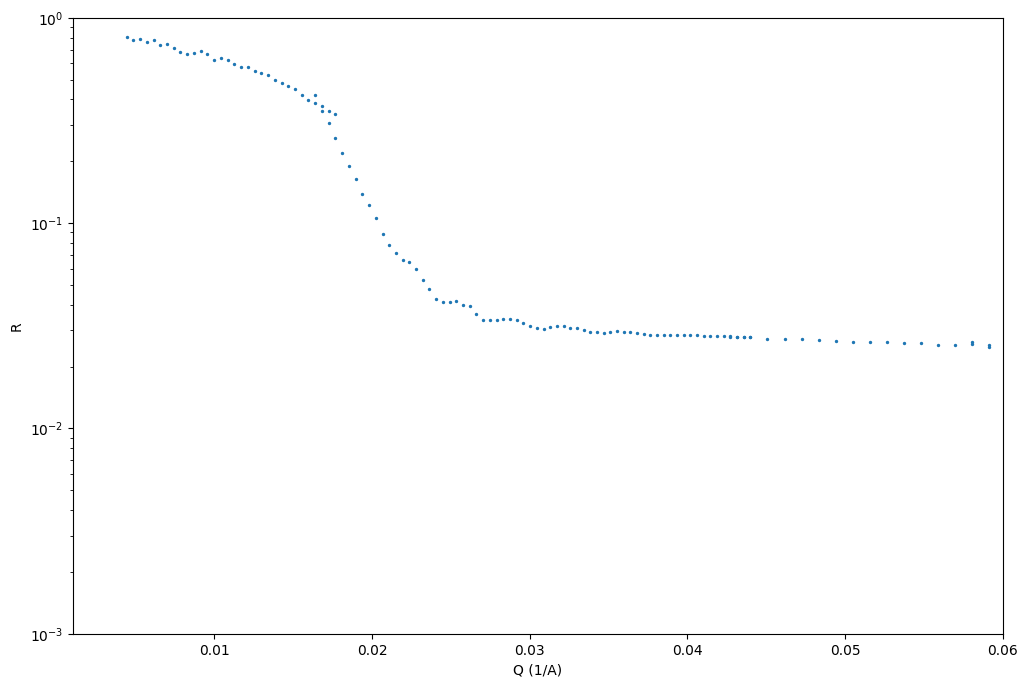

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
refl.plot.scatter(x="Q", y="R", logy=True, s=2, ax=ax)
ax.set_xlabel("Q (1/A)")
ax.set_ylabel("R")
ax.set_ylim(1e-3, 1)
ax.set_xlim(0.001, 0.06)
sliced = (
    refl.loc[refl["Q"] < 0.06].loc[refl["Q"] > 0.001].copy()
)  # Slice the data to only include the region of interest
sliced.columns = sliced.columns.str.lower()
# replace regions where q repeats with the average value across the dataframe
sliced = sliced.groupby("q").mean().reset_index()
sliced

In [ ]:
from refnx.dataset import ReflectDataset

import pyref.fitting as fit

In [ ]:
sliced["Q"] = sliced["q"]

(<Figure size 640x480 with 1 Axes>, <Axes: >)

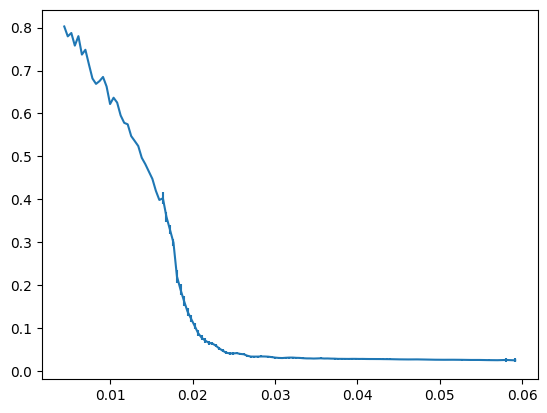

In [ ]:
ds = ReflectDataset(
    sliced[["q", "r", "r_err"]].to_numpy().T,
)
ds.plot()

________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:    'Vacuum'    
________________________________________________________________________________
Parameters:  'Vacuum_slab' 
<Parameter:'Vacuum_thick' , value=0  (fixed) , bounds=[0.0, 100.0]>
<Parameter:'Vacuum_rough' , value=0  (fixed) , bounds=[0.0, 100.0]>
<Parameter: 'Vacuum_rho'  , value=1  (fixed) , bounds=[0.1, 1.5]>
________________________________________________________________________________
Parameters:     'Bulk'     
________________________________________________________________________________
Parameters:   'Bulk_slab'  
<Parameter: 'Bulk_thick'  , value=1280          , bounds=[1000.0, 1500.0]>
<Parameter: 'Bulk_rough'  , value=50          , bounds=[0.0, 100.0]>
<Parameter:  'Bulk_rho'   , value=1          , bounds=[0.1, 1.5]>
___________________________________________

<Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>

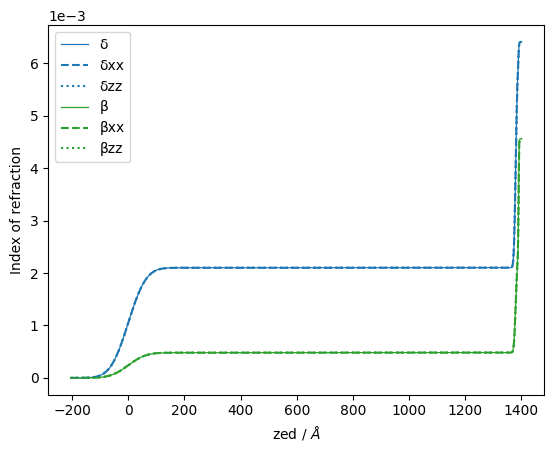

In [ ]:
vac = fit.MaterialSLD("", energy=250.0, density=1.0, name="Vacuum")(0, 0)
vac.sld.density.setp(vary=False, bounds=(0.1, 1.5))
vac.thick.setp(vary=False, bounds=(0, 100))
vac.rough.setp(vary=False, bounds=(0, 100))

bulk = fit.MaterialSLD("C10H14S1", energy=250.0, density=1.0, name="Bulk")(1280, 50)
bulk.sld.density.setp(vary=True, bounds=(0.1, 1.5))
bulk.thick.setp(vary=True, bounds=(1000, 1500))
bulk.rough.setp(vary=True, bounds=(0, 100))

inter = fit.MaterialSLD("C10H14S1", energy=250.0, density=1.0, name="Inter")(100, 50)
inter.sld.density.setp(vary=True, bounds=(0.1, 1.5))
inter.thick.setp(vary=True, bounds=(0, 100))
inter.rough.setp(vary=True, bounds=(0, 100))

sio2 = fit.MaterialSLD("SiO2", energy=250.0, density=2.3, name="SiO2")(10, 5)
sio2.sld.density.setp(vary=True, bounds=(0.1, 1.5))
sio2.thick.setp(vary=True, bounds=(0, 12))
sio2.rough.setp(vary=True, bounds=(0, 12))

si = fit.MaterialSLD("Si", energy=250.0, density=2.5, name="Silicon")(0, 1.5)
si.sld.density.setp(vary=True, bounds=(2, 3))
si.thick.setp(vary=False, bounds=(0, 1))
si.rough.setp(vary=True, bounds=(0, 2))

struct = vac | bulk | inter | sio2 | si
print(struct.parameters)
struct.plot()

<Axes: xlabel='z / Å', ylabel='Index of refraction'>

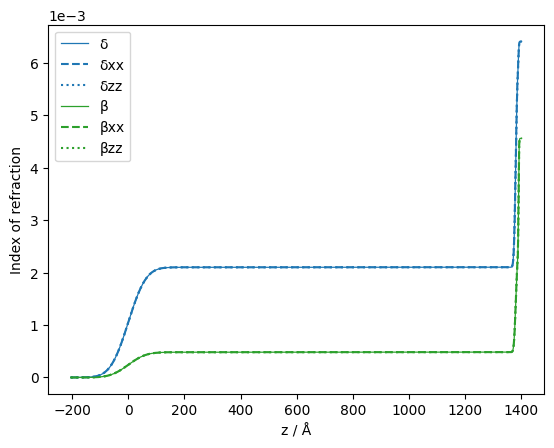

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def plot_sld_profile(
    optical_constants, thicknesses, roughnesses, layer_names, ax=None, align=0
):
    """
    Standalone function to plot SLD profile from lists.

    Parameters
    ----------
    optical_constants : list of complex or np.ndarray
        List of optical constants (n) for each layer. Each can be a complex scalar or array (2 or 3 elements).
    thicknesses : list of float
        List of thicknesses for each layer (Å). First and last should be 0 (substrate/superstrate).
    roughnesses : list of float
        List of roughnesses for each interface (Å). Length should match number of layers.
    layer_names : list of str
        List of names for each layer.
    ax : matplotlib.axes.Axes, optional
        Axis to plot on.
    align : int, optional
        Interface to align at z=0.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    # Prepare slabs and tensors
    n_layers = len(optical_constants)
    slabs = np.zeros((n_layers, 4))
    tensors = np.zeros((n_layers, 3, 3), dtype=complex)

    for i, (n, t, r) in enumerate(zip(optical_constants, thicknesses, roughnesses)):
        slabs[i, 0] = t
        # Accept n as scalar or array
        if isinstance(n, (float, complex)):
            n_arr = np.array([n, n, n])
        else:
            n_arr = np.asarray(n)
            if n_arr.shape == (2,):
                n_arr = np.array([n_arr[0], n_arr[0], n_arr[1]])
            elif n_arr.shape == (3,):
                pass
            elif n_arr.shape == (3, 3):
                n_arr = np.diagonal(n_arr)
            else:
                raise ValueError(
                    "Optical constant must be scalar, (2,), (3,), or (3,3)"
                )
        slabs[i, 1] = n_arr.real.mean()
        slabs[i, 2] = n_arr.imag.mean()
        slabs[i, 3] = r
        tensors[i] = np.diag(n_arr)

    # Compute z and profile (adapted from birefringence_profile)
    def birefringence_profile(slabs, tensor, z=None):
        nlayers = np.size(slabs, 0) - 2
        layers = np.copy(slabs)
        layers[:, 0] = np.fabs(slabs[:, 0])
        layers[:, 3] = np.fabs(slabs[:, 3])
        layers[0, 0] = layers[-1, 0] = 0
        dist = np.cumsum(layers[:-1, 0])
        total_film_thickness = int(np.round(dist[-1])) if len(dist) else 1
        if z is None:
            zstart = -5 - 4 * np.fabs(slabs[1, 3])
            zend = 5 + dist[-1] + 4 * layers[-1, 3]
            zed = np.linspace(zstart, zend, num=total_film_thickness * 2)
        else:
            zed = np.asfarray(z)
        reduced_tensor = tensor.diagonal(0, 1, 2)
        tensor_erf = np.ones((len(zed), 3), dtype=float) * reduced_tensor[0]
        delta_n = reduced_tensor[1:] - reduced_tensor[:-1]
        from refnx.reflect.interface import Erf, Step

        erf_f = Erf()
        sigma = layers[1:, 3]
        for i in range(nlayers + 1):
            f = erf_f
            if sigma[i] == 0:
                f = Step()
            tensor_erf += (
                delta_n[None, i, :] * f(zed, scale=sigma[i], loc=dist[i])[:, None]
            )
        return zed, tensor_erf

    zed, prof = birefringence_profile(slabs, tensors)

    # Align if needed
    offset = 0
    if align != 0:
        align = int(align)
        if align >= len(slabs) - 1 or align < -1 * len(slabs):
            raise RuntimeError("abs(align) has to be less than len(slabs) - 1")
        slabs[0, 0] = slabs[-1, 0] = 0.0
        if align >= 0:
            offset = np.sum(slabs[: align + 1, 0])
        else:
            offset = np.sum(slabs[:align, 0])
    zed = zed - offset

    # Plot
    if ax is None:
        _, ax = plt.subplots()
    iso = prof.sum(axis=1) / 3
    ax.plot(zed, np.real(iso), color="C0", zorder=20, label="δ", linewidth=0.9)
    ax.plot(
        zed, np.real(prof[:, 0]), color="C0", zorder=10, label="δxx", linestyle="--"
    )
    ax.plot(zed, np.real(prof[:, 2]), color="C0", zorder=10, label="δzz", linestyle=":")
    ax.plot(zed, np.imag(iso), color="C2", zorder=20, label="β", linewidth=0.9)
    ax.plot(
        zed, np.imag(prof[:, 0]), color="C2", zorder=10, label="βxx", linestyle="--"
    )
    ax.plot(zed, np.imag(prof[:, 2]), color="C2", zorder=10, label="βzz", linestyle=":")
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Index of refraction")
    ax.set_xlabel("z / Å")
    ax.legend()
    return ax


# test the function
plot_sld_profile(
    [
        vac.tensor()[0],
        bulk.tensor()[0],
        inter.tensor()[0],
        sio2.tensor()[0],
        si.tensor()[0],
    ],
    [
        vac.thick.value,
        bulk.thick.value,
        inter.thick.value,
        sio2.thick.value,
        si.thick.value,
    ],
    [
        vac.rough.value,
        bulk.rough.value,
        inter.rough.value,
        sio2.rough.value,
        si.rough.value,
    ],
    ["Vacuum", "Bulk", "Interlayer", "SiO2", "Silicon"],
)

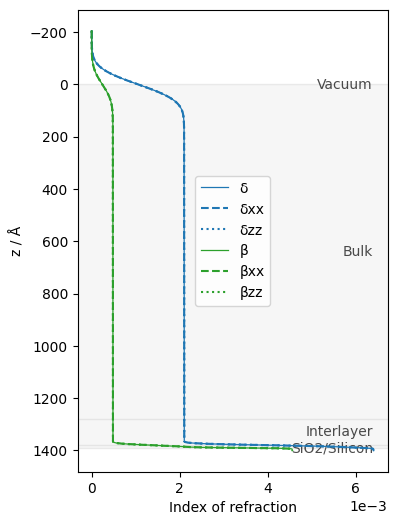

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def plot_sld_profile(
    optical_constants,
    thicknesses,
    roughnesses,
    layer_names,
    ax=None,
    align=0,
    vertical=False,
    show_names=False,
):
    """
    Standalone function to plot SLD profile from lists.

    Parameters
    ----------
    optical_constants : list of complex or np.ndarray
        List of optical constants (n) for each layer. Each can be a complex scalar or array (2 or 3 elements).
    thicknesses : list of float
        List of thicknesses for each layer (Å). First and last should be 0 (substrate/superstrate).
    roughnesses : list of float
        List of roughnesses for each interface (Å). Length should match number of layers.
    layer_names : list of str
        List of names for each layer.
    ax : matplotlib.axes.Axes, optional
        Axis to plot on.
    align : int, optional
        Interface to align at z=0.
    vertical : bool, optional
        If True, plot the structure vertically (stacked as in real sample).
    show_names : bool, optional
        If True, annotate the plot with layer names.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    # Prepare slabs and tensors
    n_layers = len(optical_constants)
    slabs = np.zeros((n_layers, 4))
    tensors = np.zeros((n_layers, 3, 3), dtype=complex)

    for i, (n, t, r) in enumerate(zip(optical_constants, thicknesses, roughnesses)):
        slabs[i, 0] = t
        # Accept n as scalar or array
        if isinstance(n, (float, complex)):
            n_arr = np.array([n, n, n])
        else:
            n_arr = np.asarray(n)
            if n_arr.shape == (2,):
                n_arr = np.array([n_arr[0], n_arr[0], n_arr[1]])
            elif n_arr.shape == (3,):
                pass
            elif n_arr.shape == (3, 3):
                n_arr = np.diagonal(n_arr)
            else:
                raise ValueError(
                    "Optical constant must be scalar, (2,), (3,), or (3,3)"
                )
        slabs[i, 1] = n_arr.real.mean()
        slabs[i, 2] = n_arr.imag.mean()
        slabs[i, 3] = r
        tensors[i] = np.diag(n_arr)

    # Compute z and profile (adapted from birefringence_profile)
    def birefringence_profile(slabs, tensor, z=None):
        nlayers = np.size(slabs, 0) - 2
        layers = np.copy(slabs)
        layers[:, 0] = np.fabs(slabs[:, 0])
        layers[:, 3] = np.fabs(slabs[:, 3])
        layers[0, 0] = layers[-1, 0] = 0
        dist = np.cumsum(layers[:-1, 0])
        total_film_thickness = int(np.round(dist[-1])) if len(dist) else 1
        if z is None:
            zstart = -5 - 4 * np.fabs(slabs[1, 3])
            zend = 5 + dist[-1] + 4 * layers[-1, 3]
            zed = np.linspace(zstart, zend, num=total_film_thickness * 2)
        else:
            zed = np.asfarray(z)
        reduced_tensor = tensor.diagonal(0, 1, 2)
        tensor_erf = np.ones((len(zed), 3), dtype=float) * reduced_tensor[0]
        delta_n = reduced_tensor[1:] - reduced_tensor[:-1]
        from refnx.reflect.interface import Erf, Step

        erf_f = Erf()
        sigma = layers[1:, 3]
        for i in range(nlayers + 1):
            f = erf_f
            if sigma[i] == 0:
                f = Step()
            tensor_erf += (
                delta_n[None, i, :] * f(zed, scale=sigma[i], loc=dist[i])[:, None]
            )
        return zed, tensor_erf

    zed, prof = birefringence_profile(slabs, tensors)

    # Align if needed
    offset = 0
    if align != 0:
        align = int(align)
        if align >= len(slabs) - 1 or align < -1 * len(slabs):
            raise RuntimeError("abs(align) has to be less than len(slabs) - 1")
        slabs[0, 0] = slabs[-1, 0] = 0.0
        if align >= 0:
            offset = np.sum(slabs[: align + 1, 0])
        else:
            offset = np.sum(slabs[:align, 0])
    zed = zed - offset

    # Plot
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 4) if not vertical else (4, 6))
    iso = prof.sum(axis=1) / 3

    # Choose orientation
    if not vertical:
        ax.plot(zed, np.real(iso), color="C0", zorder=20, label="δ", linewidth=0.9)
        ax.plot(
            zed, np.real(prof[:, 0]), color="C0", zorder=10, label="δxx", linestyle="--"
        )
        ax.plot(
            zed, np.real(prof[:, 2]), color="C0", zorder=10, label="δzz", linestyle=":"
        )
        ax.plot(zed, np.imag(iso), color="C2", zorder=20, label="β", linewidth=0.9)
        ax.plot(
            zed, np.imag(prof[:, 0]), color="C2", zorder=10, label="βxx", linestyle="--"
        )
        ax.plot(
            zed, np.imag(prof[:, 2]), color="C2", zorder=10, label="βzz", linestyle=":"
        )
        ax.set_xlabel("z / Å")
        ax.set_ylabel("Index of refraction")
    else:
        ax.plot(np.real(iso), zed, color="C0", zorder=20, label="δ", linewidth=0.9)
        ax.plot(
            np.real(prof[:, 0]), zed, color="C0", zorder=10, label="δxx", linestyle="--"
        )
        ax.plot(
            np.real(prof[:, 2]), zed, color="C0", zorder=10, label="δzz", linestyle=":"
        )
        ax.plot(np.imag(iso), zed, color="C2", zorder=20, label="β", linewidth=0.9)
        ax.plot(
            np.imag(prof[:, 0]), zed, color="C2", zorder=10, label="βxx", linestyle="--"
        )
        ax.plot(
            np.imag(prof[:, 2]), zed, color="C2", zorder=10, label="βzz", linestyle=":"
        )
        ax.set_ylabel("z / Å")
        ax.set_xlabel("Index of refraction")
        ax.invert_yaxis()  # substrate at bottom

    ax.ticklabel_format(axis="x" if vertical else "y", style="sci", scilimits=(0, 0))
    ax.legend()

    # Add layer names if requested
    if show_names and layer_names is not None:
        # Compute interface positions
        interface_pos = np.cumsum([0] + [t for t in thicknesses[:-1]])
        for i, (name, z0, t) in enumerate(zip(layer_names, interface_pos, thicknesses)):
            if not vertical:
                x = z0 + t / 2
                y = ax.get_ylim()[1] * 0.95
                ax.text(
                    x,
                    y,
                    name,
                    rotation=90,
                    va="top",
                    ha="center",
                    fontsize=10,
                    color="k",
                    alpha=0.7,
                )
                # Optionally, shade the layer
                ax.axvspan(z0, z0 + t, color="grey", alpha=0.07, zorder=0)
            else:
                y = z0 + t / 2
                x = ax.get_xlim()[1] * 0.95
                ax.text(
                    x,
                    y,
                    name,
                    va="center",
                    ha="right",
                    fontsize=10,
                    color="k",
                    alpha=0.7,
                )
                ax.axhspan(z0, z0 + t, color="grey", alpha=0.07, zorder=0)

    return ax


plot_sld_profile(
    [
        vac.tensor()[0],
        bulk.tensor()[0],
        inter.tensor()[0],
        sio2.tensor()[0],
        si.tensor()[0],
    ],
    [
        vac.thick.value,
        bulk.thick.value,
        inter.thick.value,
        sio2.thick.value,
        si.thick.value,
    ],
    [
        vac.rough.value,
        bulk.rough.value,
        inter.rough.value,
        sio2.rough.value,
        si.rough.value,
    ],
    ["Vacuum", "Bulk", "Interlayer", "", "SiO2/Silicon"],
    vertical=True,  # Show stack vertically
    show_names=True,  # Show slab names
)
plt.show()

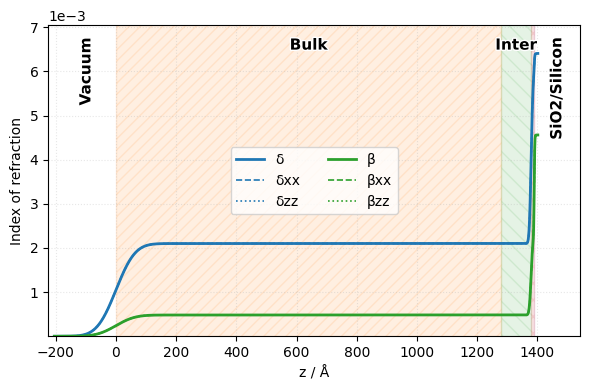

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def plot_sld_profile(
    optical_constants,
    thicknesses,
    roughnesses,
    layer_names,
    ax=None,
    align=0,
    vertical=False,
    show_names=False,
    layer_alpha=0.12,
    layer_colors=None,
    hatch_patterns=None,
    text_color="black",
    text_outline=True,
    text_outline_color="white",
    text_outline_width=2,
    text_offset=0.04,
    fontweight="bold",
):
    """
    Standalone function to plot SLD profile from lists, with improved visuals.

    Parameters
    ----------
    optical_constants : list of complex or np.ndarray
        List of optical constants (n) for each layer. Each can be a complex scalar or array (2 or 3 elements).
    thicknesses : list of float
        List of thicknesses for each layer (Å). First and last should be 0 (substrate/superstrate).
    roughnesses : list of float
        List of roughnesses for each interface (Å). Length should match number of layers.
    layer_names : list of str
        List of names for each layer.
    ax : matplotlib.axes.Axes, optional
        Axis to plot on.
    align : int, optional
        Interface to align at z=0.
    vertical : bool, optional
        If True, plot the structure vertically (stacked as in real sample).
    show_names : bool, optional
        If True, annotate the plot with layer names.
    layer_alpha : float
        Transparency for layer shading.
    layer_color : str
        Color for layer shading.
    text_color : str
        Color for layer name text.
    text_outline : bool
        If True, add outline to text for readability.
    text_outline_color : str
        Outline color for text.
    text_outline_width : float
        Outline width for text.
    text_offset : float
        Offset for text label as a fraction of axis range.
    fontweight : str
        Font weight for layer names.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    from matplotlib.patheffects import withStroke

    n_layers = len(optical_constants)
    slabs = np.zeros((n_layers, 4))
    tensors = np.zeros((n_layers, 3, 3), dtype=complex)

    for i, (n, t, r) in enumerate(zip(optical_constants, thicknesses, roughnesses)):
        slabs[i, 0] = t
        if isinstance(n, (float, complex)):
            n_arr = np.array([n, n, n])
        else:
            n_arr = np.asarray(n)
            if n_arr.shape == (2,):
                n_arr = np.array([n_arr[0], n_arr[0], n_arr[1]])
            elif n_arr.shape == (3,):
                pass
            elif n_arr.shape == (3, 3):
                n_arr = np.diagonal(n_arr)
            else:
                raise ValueError(
                    "Optical constant must be scalar, (2,), (3,), or (3,3)"
                )
        slabs[i, 1] = n_arr.real.mean()
        slabs[i, 2] = n_arr.imag.mean()
        slabs[i, 3] = r
        tensors[i] = np.diag(n_arr)

    def birefringence_profile(slabs, tensor, z=None):
        nlayers = np.size(slabs, 0) - 2
        layers = np.copy(slabs)
        layers[:, 0] = np.fabs(slabs[:, 0])
        layers[:, 3] = np.fabs(slabs[:, 3])
        layers[0, 0] = layers[-1, 0] = 0
        dist = np.cumsum(layers[:-1, 0])
        total_film_thickness = int(np.round(dist[-1])) if len(dist) else 1
        if z is None:
            zstart = -5 - 4 * np.fabs(slabs[1, 3])
            zend = 6 + dist[-1] + 4 * layers[-1, 3]
            zed = np.linspace(zstart, zend, num=total_film_thickness * 2)
        else:
            zed = np.asfarray(z)
        reduced_tensor = tensor.diagonal(0, 1, 2)
        tensor_erf = np.ones((len(zed), 3), dtype=float) * reduced_tensor[0]
        delta_n = reduced_tensor[1:] - reduced_tensor[:-1]
        from refnx.reflect.interface import Erf, Step

        erf_f = Erf()
        sigma = layers[1:, 3]
        for i in range(nlayers + 1):
            f = erf_f
            if sigma[i] == 0:
                f = Step()
            tensor_erf += (
                delta_n[None, i, :] * f(zed, scale=sigma[i], loc=dist[i])[:, None]
            )
        return zed, tensor_erf

    zed, prof = birefringence_profile(slabs, tensors)

    # Align if needed
    offset = 0
    if align != 0:
        align = int(align)
        if align >= len(slabs) - 1 or align < -1 * len(slabs):
            raise RuntimeError("abs(align) has to be less than len(slabs) - 1")
        slabs[0, 0] = slabs[-1, 0] = 0.0
        if align >= 0:
            offset = np.sum(slabs[: align + 1, 0])
        else:
            offset = np.sum(slabs[:align, 0])
    zed = zed - offset

    # Plot
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 4) if not vertical else (4, 6))
    iso = prof.sum(axis=1) / 3

    if layer_colors is None:
        from itertools import cycle

        color_cycle = cycle(plt.get_cmap("tab10").colors)
        layer_colors = [next(color_cycle) for _ in range(n_layers)]
    if hatch_patterns is None:
        hatch_patterns = ["", "///", "\\\\", "xx", "++", "..", "**", "oo", "--", "||"]
        hatch_patterns = (hatch_patterns * ((n_layers // len(hatch_patterns)) + 1))[
            :n_layers
        ]

    # Layer shading and label positions
    if show_names and layer_names is not None:
        interface_pos = np.cumsum([0] + [t for t in thicknesses[:-1]])
        axis_range = ax.get_xlim() if vertical else ax.get_ylim()
        for i, (name, z0, t) in enumerate(zip(layer_names, interface_pos, thicknesses)):
            if i == 0:
                continue
            if not vertical:
                ax.axvspan(
                    z0,
                    z0 + t,
                    color=layer_colors[i],
                    alpha=layer_alpha,
                    zorder=0,
                    hatch=hatch_patterns[i],
                )
            else:
                ax.axhspan(
                    z0,
                    z0 + t,
                    color=layer_colors[i],
                    alpha=layer_alpha,
                    zorder=0,
                    hatch=hatch_patterns[i],
                )

    # Main traces
    lw_main = 2.0
    lw_sub = 1.2
    ax.plot(
        zed if not vertical else np.real(iso),
        np.real(iso) if not vertical else zed,
        color="C0",
        zorder=20,
        label="δ",
        linewidth=lw_main,
    )
    ax.plot(
        zed if not vertical else np.real(prof[:, 0]),
        np.real(prof[:, 0]) if not vertical else zed,
        color="C0",
        zorder=10,
        label="δxx",
        linestyle="--",
        linewidth=lw_sub,
    )
    ax.plot(
        zed if not vertical else np.real(prof[:, 2]),
        np.real(prof[:, 2]) if not vertical else zed,
        color="C0",
        zorder=10,
        label="δzz",
        linestyle=":",
        linewidth=lw_sub,
    )
    ax.plot(
        zed if not vertical else np.imag(iso),
        np.imag(iso) if not vertical else zed,
        color="C2",
        zorder=20,
        label="β",
        linewidth=lw_main,
    )
    ax.plot(
        zed if not vertical else np.imag(prof[:, 0]),
        np.imag(prof[:, 0]) if not vertical else zed,
        color="C2",
        zorder=10,
        label="βxx",
        linestyle="--",
        linewidth=lw_sub,
    )
    ax.plot(
        zed if not vertical else np.imag(prof[:, 2]),
        np.imag(prof[:, 2]) if not vertical else zed,
        color="C2",
        zorder=10,
        label="βzz",
        linestyle=":",
        linewidth=lw_sub,
    )

    # Axis labels and limits
    if not vertical:
        ax.set_xlabel("z / Å")
        ax.set_ylabel("Index of refraction")
        ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
        ax.set_ylim(
            np.min(np.real(iso)) - 0.1 * np.fabs(np.min(np.real(iso))),
            np.max(np.real(iso)) + 0.1 * np.fabs(np.max(np.real(iso))),
        )
        ax.set_xlim(
            np.min(zed) - 0.1 * np.fabs(np.min(zed)),
            np.max(zed) + 0.1 * np.fabs(np.max(zed)),
        )
    else:
        ax.set_ylabel("z / Å")
        ax.set_xlabel("Index of refraction")
        ax.invert_yaxis()
        ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
        ax.set_xlim(
            np.min(np.real(iso)) - 0.1 * np.fabs(np.min(np.real(iso))),
            np.max(np.real(iso)) + 0.1 * np.fabs(np.max(np.real(iso))),
        )
        ax.set_ylim(
            np.max(zed) + 0.1 * np.fabs(np.max(zed)),
            np.min(zed) - 0.1 * np.fabs(np.min(zed)),
        )

    # Add layer names, offset from traces
    if show_names and layer_names is not None:
        interface_pos = np.cumsum([0] + [t for t in thicknesses[:-1]])
        if not vertical:
            y_range = ax.get_ylim()
            y_span = y_range[1] - y_range[0]
            for i, (name, z0, t) in enumerate(
                zip(layer_names, interface_pos, thicknesses)
            ):
                x = (
                    z0 - 2 * np.fabs(slabs[1, 3])
                    if i == 0
                    else ax.get_xlim()[1] * 0.95
                    if i == len(layer_names) - 1
                    else z0 + t / 2
                )
                y = y_range[1] - text_offset * y_span
                # Determine text rotation
                # Create a temporary text object to measure its extent without drawing it
                temp_text_obj = ax.text(
                    x,
                    y,
                    name,
                    rotation=0,  # Measure unrotated text
                    va="top",
                    ha="center",
                    fontsize=11,
                    color=text_color,
                    fontweight=fontweight,
                    visible=False,
                )  # Invisible

                renderer = ax.figure.canvas.get_renderer()
                # Ensure the renderer is valid, which might require the figure to have been drawn once
                if renderer is None:  # pragma: no cover
                    ax.figure.canvas.draw()
                    renderer = ax.figure.canvas.get_renderer()

                bbox = temp_text_obj.get_window_extent(renderer=renderer)

                # Transform bbox width from display coordinates to data coordinates (x-axis)
                if bbox.width > 0 and bbox.height > 0:  # Ensure bbox is valid
                    point1_display = (bbox.x0, bbox.y0)
                    point2_display = (bbox.x1, bbox.y0)  # Use x1 for width calculation

                    # Transform to data coordinates
                    point1_data = ax.transData.inverted().transform(point1_display)
                    point2_data = ax.transData.inverted().transform(point2_display)

                    text_width_in_data_coords = abs(point2_data[0] - point1_data[0])
                else:  # pragma: no cover
                    text_width_in_data_coords = 0

                temp_text_obj.remove()  # Clean up the temporary text object

                # Decide rotation based on comparison
                # t is the slab thickness for the current layer
                # Rotate if text width is greater than slab thickness and slab thickness is positive
                rotate_text = (
                    text_width_in_data_coords > t
                )  # Avoid rotation for zero/tiny thickness unless text is wider

                actual_rotation = 90 if rotate_text else 0

                txt = ax.text(
                    x,
                    y,
                    name,
                    rotation=actual_rotation,
                    va="top",
                    ha="center",
                    fontsize=11,
                    color=text_color,
                    fontweight=fontweight,
                    zorder=30,
                )
                if text_outline:
                    txt.set_path_effects(
                        [
                            withStroke(
                                linewidth=text_outline_width,
                                foreground=text_outline_color,
                            )
                        ]
                    )
        else:
            x_range = ax.get_xlim()
            x_span = x_range[1] - x_range[0]
            for i, (name, z0, t) in enumerate(
                zip(layer_names, interface_pos, thicknesses)
            ):
                y = (
                    z0 - 2 * np.fabs(slabs[1, 3])
                    if i == 0
                    else ax.get_ylim()[0] * 0.95
                    if i == len(layer_names) - 1
                    else z0 + t / 2
                )
                x = x_range[1] - text_offset * x_span
                txt = ax.text(
                    x,
                    y,
                    name,
                    va="center",
                    ha="right",
                    fontsize=11,
                    color=text_color,
                    fontweight=fontweight,
                    zorder=30,
                )
                if text_outline:
                    txt.set_path_effects(
                        [
                            withStroke(
                                linewidth=text_outline_width,
                                foreground=text_outline_color,
                            )
                        ]
                    )
    ax.legend(
        loc="upper left" if vertical else "center",
        fontsize=10,
        frameon=True,
        fancybox=True,
        ncol=(
            2
            if optical_constants[0].shape == (3,)
            or optical_constants[0].shape == (3, 3)
            else 1
        ),
    )
    # set legend zorder to be above the plot
    ax.get_legend().set_zorder(100)
    ax.grid(True, which="both", linestyle=":", alpha=0.3)
    plt.tight_layout()
    return ax


# Example usage:
plot_sld_profile(
    [
        vac.tensor()[0],
        bulk.tensor()[0],
        inter.tensor()[0],
        sio2.tensor()[0],
        si.tensor()[0],
    ],
    [
        vac.thick.value,
        bulk.thick.value,
        inter.thick.value,
        sio2.thick.value,
        si.thick.value,
    ],
    [
        vac.rough.value,
        bulk.rough.value,
        inter.rough.value,
        sio2.rough.value,
        si.rough.value,
    ],
    ["Vacuum", "Bulk", "Inter", "", "SiO2/Silicon"],
    vertical=False,
    show_names=True,
    layer_colors=None,
    hatch_patterns=None,
)
plt.show()

In [ ]:
from refnx._lib.emcee.moves import DEMove
from refnx.analysis import Objective, Transform

-473125373115851.44
________________________________________________________________________________
Parameters:      None      
<Parameter: 'Bulk_thick'  , value=1280          , bounds=[1000.0, 1500.0]>
<Parameter: 'Bulk_rough'  , value=50          , bounds=[0.0, 100.0]>
<Parameter:  'Bulk_rho'   , value=1          , bounds=[0.1, 1.5]>
<Parameter: 'Inter_thick' , value=100          , bounds=[0.0, 100.0]>
<Parameter: 'Inter_rough' , value=50          , bounds=[0.0, 100.0]>
<Parameter:  'Inter_rho'  , value=1          , bounds=[0.1, 1.5]>
<Parameter: 'SiO2_thick'  , value=10          , bounds=[0.0, 12.0]>
<Parameter: 'SiO2_rough'  , value=5          , bounds=[0.0, 12.0]>
<Parameter:  'SiO2_rho'   , value=2.3          , bounds=[0.1, 1.5]>
<Parameter:'Silicon_rough', value=1.5          , bounds=[0.0, 2.0]>
<Parameter: 'Silicon_rho' , value=2.5          , bounds=[2.0, 3.0]>


(<Figure size 640x480 with 1 Axes>, <Axes: >)

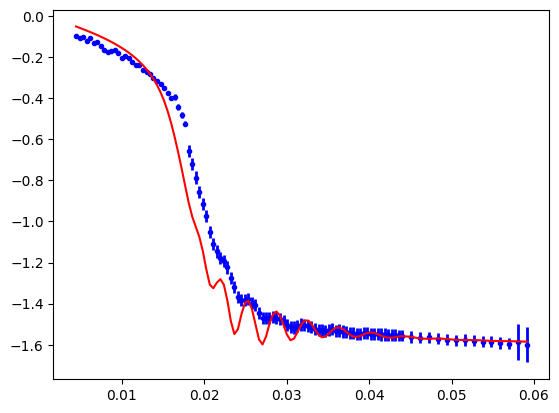

In [ ]:
model = fit.ReflectModel(
    struct,
    250.0,
    "p",
    name="test",
    bkg=min(sliced["r"]),
)
obj = Objective(model, ds, transform=Transform("logY"))
# lpe = fit.LogpExtra(obj)
# obj.logp_extra = lpe
print(obj.logl())
print(obj.varying_parameters())
obj.plot()